# CostOptimizer

Optionally-constrained PSO optimization of EconomicLoss function for CaUWMET model. 


In [148]:
#from IPython.core.debugger import set_trace

import time
import numpy as np
import matplotlib.pyplot as plt
import warnings

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.termination import get_termination
from pymoo.optimize import minimize

from src.modelLogic.modelLogic import ModelLogic
from src.modelLogic.inputData import InputData
from src.modelLogic.storageUtilities import StorageUtilities
from src.modelLogic.inputDataLocations import InputDataLocations

warnings.filterwarnings('ignore')

### PyMoo Optimization Problem Class ###

class CostOptimizer(ElementwiseProblem): 
    '''
    This class is a PyMoo problem class designed to simulate the effects of wmoSupply level...
    ...on water usage cost optimization across various sources.
    
    The objective function f(x) has an equality constraint g(x) = wmoSupply.
    The algorithm is a particle swarm optimizer with default settings. 
    
    https://pymoo.org/
    '''
    def __init__(self, 
                 lowerBounds: list,          # lower bound of each WMO type for a given scenario - len(list)=8
                 upperBounds: list,          # upper bound of each WMO type for a given scenario - len(list)=8
                 modelLogic: ModelLogic,     # prepared ModelLogic object with InputData and StorageUtilities
                 wmoFloor=None,              # how low are we constraining the sum longterm WMOs?
                 wmoSupply=None,             # how high are we constraining the sum longterm WMOs?
                 **kwargs):    
        '''
        Initializing the CostOptimizer class requires parameterizing a CaUWMET model for a given contractor and(?) wmoSupply.
        Inputs:
            wmoFloor/wmoSupply :: number > 0, max sum of the longtermWMO allocations
            lowerBounds/upperBounds :: list of numbers, length 8
            modelLogic :: ModelLogic object loaded with InputData, StorageUtilities, and Contractor
        '''
        self.wmoFloor = wmoFloor if wmoFloor is not None else None
        self.wmoSupply = wmoSupply if wmoSupply is not None else None
        self.n_ieq_constr = sum([i != None for i in [self.wmoFloor, self.wmoSupply]])
        self.lowerBounds = lowerBounds
        self.upperBounds = upperBounds
        self.objectiveFunction = modelLogic.executeModelLogicForContractor
        
        # parameterize the objective function
        super().__init__(
            n_var=8, n_obj=1, n_ieq_constr=self.n_ieq_constr, 
            xl=self.lowerBounds, xu=self.upperBounds,  # xl and xu set f bounds 
            **kwargs
        )


    def _evaluate(self, x, out, *args, **kwargs):
        '''
        Inputs:
           x :: list of numbers, length 8
        Returns objective function f(x) as execution of model logic
        Returns inequality constraints g(x)
        '''
        tic = time.perf_counter()
        if self.n_ieq_constr > 0:
            out["F"] = self.objectiveFunction(x)
            G1 = self.wmoFloor - np.sum(x)
            G2 = np.sum(x) - self.wmoSupply
            out["G"] = [G1, G2]
        else:
            out["F"] = self.objectiveFunction(x)
        toc = time.perf_counter()
        

### instantiate CaUWMET model and execute MOO problem ###

inputData = InputData(InputDataLocations())
modelLogic = ModelLogic(inputData, StorageUtilities())
modelLogic.contractor = 'Metropolitan Water District of Southern California'

wmoSupply = 500  # num > 0 or None
wmoFloor = 200  # num > 0 or None

year = '2045'

# upperBounds = [
#     inputData.longtermWMOSurfaceVolumeLimit[inputData.longtermWMOSurfaceVolumeLimit.index==modelLogic.contractor][year][0],
#     inputData.longtermWMOGroundwaterVolumeLimit[inputData.longtermWMOGroundwaterVolumeLimit.index==modelLogic.contractor][year][0],
#     inputData.longtermWMODesalinationVolumeLimit[inputData.longtermWMODesalinationVolumeLimit.index==modelLogic.contractor][year][0],
#     inputData.longtermWMORecycledVolumeLimit[inputData.longtermWMORecycledVolumeLimit.index==modelLogic.contractor][year][0],
#     inputData.longtermWMOPotableReuseVolumeLimit[inputData.longtermWMOPotableReuseVolumeLimit.index==modelLogic.contractor][year][0],
#     inputData.longtermWMOTransfersExchangesVolumeLimit[inputData.longtermWMOTransfersExchangesVolumeLimit.index==modelLogic.contractor][year][0],
#     inputData.longtermWMOOtherSupplyVolumeLimit[inputData.longtermWMOOtherSupplyVolumeLimit.index==modelLogic.contractor][year][0],
#     inputData.longtermWMOConservationVolumeLimit[inputData.longtermWMOConservationVolumeLimit.index==modelLogic.contractor][year][0],
# ]
upperBounds = [1000]*8
lowerBounds = [0]*8

# parameterize the problem
problem = CostOptimizer(
    wmoFloor=wmoFloor, wmoSupply=wmoSupply, 
    lowerBounds=lowerBounds, upperBounds=upperBounds,
    modelLogic=modelLogic
)

# parameterize algorithm
algorithm = PSO(
    pop_size=10,
    w=0.9, c1=5.0, c2=1.0,
    adaptive=True,
    max_velocity_rate=0.2
)

# parameterize the termination criteria
termination = get_termination("n_gen", 5)

# execute optimization
res = minimize(
    problem, 
    algorithm, 
    termination, 
    seed=42, 
    verbose=True,
    save_history=True
)
    
print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       10 |        - |       - |  0.9000 |  5.00000 |  1.00000 |  2.408911E+03 |  3.509258E+03 |             - |             -
     2 |       20 | -5.7E-02 |       3 |  0.3651 |  2.50000 |  1.50000 |  2.408911E+03 |  3.454254E+03 |             - |             -
     3 |       30 | -1.9E-02 |       3 |  0.3881 |  2.47998 |  1.52760 |  2.408911E+03 |  3.048571E+03 |             - |             -
     4 |       40 | -1.8E-01 |       3 |  0.2930 |  2.46675 |  1.54593 |  2.263009E+03 |  2.647976E+03 |             - |             -
     5 |       50 | -1.8E-01 |       3 |  0.2933 |  2.44435 |  1.57711 |  2.186967E+03 |  2.381793E+03 |             - |             -
Best solution found: 
X = None
F = None


TypeError: 'NoneType' object is not iterable

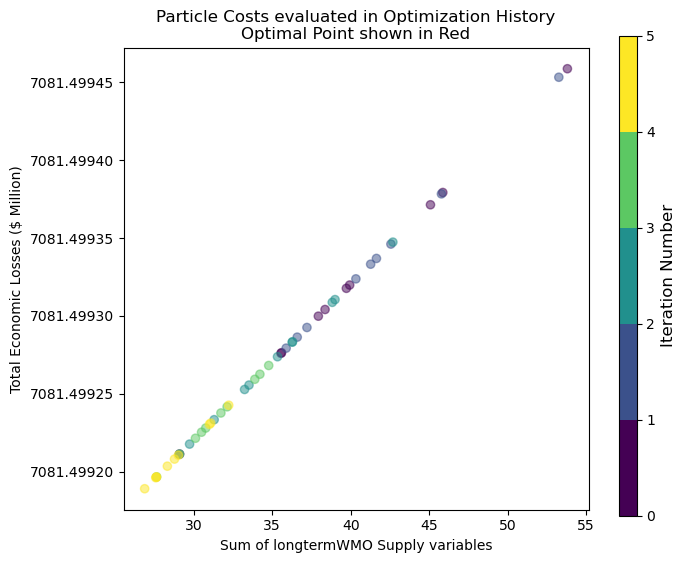

In [146]:
### plot particle results history ###

import matplotlib as mpl

X = []
F = []

for h in res.history:
    for p in h.particles:
        X.append(p._X)
        F.append(p._F)
        
TAF = np.sum(X,axis=1)
loss_millions = [f*10**-6 for f in F]
colors = [item for item in [0,1,2,3,4] for i in range(10)]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # setup the plot

cmap = plt.cm.viridis  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)] # extract all colors from map
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N
)

# define the bins and normalize
bounds = np.linspace(0, 5, 6)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax.scatter(TAF, loss_millions, c=colors, cmap=cmap, norm=norm, alpha=0.5)
ax.set_title("Particle Costs evaluated in Optimization History\nOptimal Point shown in Red")
ax.set_xlabel("Sum of longtermWMO Supply variables")
ax.set_ylabel("Total Economic Losses ($ Million)")
ax.ticklabel_format(axis="y", style="sci", useOffset=False)

# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(
    ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i'
)
ax2.set_ylabel('Iteration Number', size=12)

ax.scatter(x=sum(res.X), y=res.F*10**-6, c='red')
        

In [144]:
res.history[3].particles[0].__dict__

{'_X': array([7.5733453 , 6.7530212 , 7.79081005, 4.7504538 , 4.72805027,
        5.20746111, 8.49692076, 3.98228206]),
 '_F': array([7.08149941e+09]),
 '_G': array([  0.71765544, -50.71765544]),
 '_H': array([], dtype=float64),
 '_dF': array([], dtype=float64),
 '_dG': array([], dtype=float64),
 '_dH': array([], dtype=float64),
 '_ddF': array([], dtype=float64),
 '_ddG': array([], dtype=float64),
 '_ddH': array([], dtype=float64),
 '_CV': array([0.71765544]),
 'evaluated': {'F', 'G', 'H'},
 'data': {'V': array([-2.        ,  2.        ,  1.69706463, -2.        , -2.        ,
         -0.87732212,  0.61377801, -2.        ]),
  'n_gen': 4,
  'n_iter': 4},
 'config': {'cache': True,
  'cv_eps': 0.0,
  'cv_ieq': {'scale': None,
   'eps': 0.0,
   'pow': None,
   'func': <function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>},
  'cv_eq': {'scale': None,
   'eps': 0.0001,
   'pow': None,
   'func': <function numpy.sum(a, axis=None,

In [52]:
res.__dict__

{'opt': Population([<pymoo.core.individual.Individual object at 0x7f9890b46290>],
            dtype=object),
 'success': None,
 'message': None,
 'problem': <__main__.CostOptimizer at 0x7f98cb8b20e0>,
 'archive': None,
 'pf': None,
 'algorithm': <pymoo.algorithms.soo.nonconvex.pso.PSO at 0x7f9893297ca0>,
 'pop': Population([<pymoo.core.individual.Individual object at 0x7f9890e30100>,
            dtype=object),
 'X': array([ 1.36594634, 25.94992995, 23.00155491, 20.4671807 , 17.52608009,
        14.21988277, 10.48846256, 21.32929965]),
 'F': array([7.08150026e+09]),
 'CV': array([0.]),
 'G': array([], dtype=float64),
 'H': array([], dtype=float64),
 'start_time': 1685655201.3402004,
 'end_time': 1685655418.7405386,
 'exec_time': 217.4003381729126,
 'history': [<pymoo.algorithms.soo.nonconvex.pso.PSO at 0x7f9890e30190>,
  <pymoo.algorithms.soo.nonconvex.pso.PSO at 0x7f9890e30160>]}

#### Parallelization Test

simple PSO optimization

No constraints, attempt to parallelize with `multiprocessing` 

https://docs.python.org/3/library/multiprocessing.html?highlight=multiprocessing#multiprocessing.pool.Pool.starmap

In [90]:
### Attempt to Parallelize ###

from IPython.core.debugger import set_trace

import time
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from src.modelLogic.modelLogic import ModelLogic
from src.modelLogic.inputData import InputData
from src.modelLogic.storageUtilities import StorageUtilities
from src.modelLogic.inputDataLocations import InputDataLocations

from multiprocessing.pool import ThreadPool
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.termination import get_termination
from pymoo.optimize import minimize

# instantiate CaUWMET model and variables
inputData = InputData(InputDataLocations())
modelLogic = ModelLogic(inputData, StorageUtilities())
modelLogic.contractor = 'Metropolitan Water District of Southern California'

year = '2045'

upperBounds = [
    inputData.longtermWMOSurfaceVolumeLimit[inputData.longtermWMOSurfaceVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOGroundwaterVolumeLimit[inputData.longtermWMOGroundwaterVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMODesalinationVolumeLimit[inputData.longtermWMODesalinationVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMORecycledVolumeLimit[inputData.longtermWMORecycledVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOPotableReuseVolumeLimit[inputData.longtermWMOPotableReuseVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOTransfersExchangesVolumeLimit[inputData.longtermWMOTransfersExchangesVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOOtherSupplyVolumeLimit[inputData.longtermWMOOtherSupplyVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOConservationVolumeLimit[inputData.longtermWMOConservationVolumeLimit.index==modelLogic.contractor][year][0]
]
lowerBounds = [0]*8

# initialize the thread pool and create the runner for parallelizaiton via Starmap
n_threads = 4
pool = ThreadPool(n_threads)

### PyMoo Optimization Problem ###

class CostOptimizer(ElementwiseProblem):
    '''
    This class is a PyMoo problem class designed to simulate the effects of wmoSupply level...
    ...on water usage cost optimization across various sources.
    
    The objective function f(x) has an equality constraint g(x) = wmoSupply.
    The algorithm is a particle swarm optimizer with default settings. 
    
    https://pymoo.org/
    '''
    def __init__(self, 
                 lowerBounds: list,          # lower bound of each WMO type for a given scenario - len(list)=8
                 upperBounds: list,          # upper bound of each WMO type for a given scenario - len(list)=8
                 modelLogic: ModelLogic,     # prepared ModelLogic object with InputData and StorageUtilities
                 **kwargs):    
        '''
        Initializing the CostOptimizer class requires parameterizing a given CaUWMET model
        for a given contractor and requested wmoSupply.
        Inputs:
            upperBounds/lowerBounds :: list of numbers, length 8
            modelLogic :: ModelLogic object loaded with InputData, StorageUtilities, and Contractor
        '''
        self.lowerBounds = lowerBounds       # list length 8 lower bounding WMOs
        self.upperBounds = upperBounds       # list length 8 upper bounding WMOs
        self.objectiveFunction = modelLogic.executeModelLogicForContractor  # modelLogic.execute
        
        # parameterize the objective function
        super().__init__(
            **kwargs, n_var=8, n_obj=1, #n_eq_constr=1, 
            xl=self.lowerBounds, xu=self.upperBounds    # xl and xu set f bounds 
        )


    def _evaluate(self, X, out, *args, **kwargs):
        tic = time.perf_counter()
        
        # prepare the parameters for the pool
        params = [[X[k]] for k in range(len(X))]

        # calculate the function values in a parallelized manner and wait until done
        F = pool.starmap(self.objectiveFunction, params)
        
        # store the function values and return them.
        out["F"] = np.array(F)
        
        toc = time.perf_counter()


# parameterize the problem
problem = CostOptimizer(
    lowerBounds=lowerBounds, upperBounds=upperBounds, modelLogic=modelLogic
)

# parameterize algorithm
algorithm = PSO(
    pop_size=10,
    w=0.9, c1=5.0, c2=1.0,
    adaptive=True,
    max_velocity_rate=0.2
)

# parameterize the termination criteria
termination = get_termination("n_gen",5)

# execute optimization
res = minimize(
    problem, 
    algorithm, 
    termination, 
    seed=42, 
    verbose=True,
    save_history=True
)
    
print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))
print('Threads:', res.exec_time)

pool.close()

TypeError: 'numpy.float64' object is not iterable

# Constraint Handling Test

simple PSO optimization

no parallelization, attempt to constrain to WMOsupply

https://pymoo.org/constraints/index.html

In [34]:
from IPython.core.debugger import set_trace

import time
import numpy as np
#from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

#from tests.test_modelLogic.py import ModelLogic
#from tests.test_inputDataLocationsForTesting import InputDataLocationsForTesting
#from tests.test_storageOperations import StorageUtilities

from src.modelLogic.modelLogic import ModelLogic
from src.modelLogic.inputData import InputData
from src.modelLogic.storageUtilities import StorageUtilities
from src.modelLogic.inputDataLocations import InputDataLocations

from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.termination import get_termination
from pymoo.optimize import minimize

### PyMoo Optimization Problem ###

class CostOptimizer(Problem): #Problem):
    '''
    This class is a PyMoo problem class designed to simulate the effects of wmoSupply level...
    ...on water usage cost optimization across various sources.
    
    The objective function f(x) has an equality constraint g(x) = wmoSupply.
    The algorithm is a particle swarm optimizer with default settings. 
    
    https://pymoo.org/
    '''
    def __init__(self, 
                 wmoSupply: int,             # how much are we allocating to the longterm WMOs? int for now...
                 upperBounds: list,          # upper bound of each WMO type for a given scenario - len(list)=8
                 modelLogic: ModelLogic,     # prepared ModelLogic object with InputData and StorageUtilities
                 **kwargs):    
        '''
        Initializing the CostOptimizer class requires parameterizing a given CaUWMET model
        for a given contractor and requested wmoSupply.
        Inputs:
            wmoSupply :: integer (for now..., could later be a number)
            upperBounds :: list of numbers, length 8
            modelLogic :: ModelLogic object loaded with InputData, StorageUtilities, and Contractor
        '''
        self.wmoSupply = wmoSupply           # must be greater than 0
        self.upperBounds = upperBounds       # list length 8 upper bounding WMOs
        self.objectiveFunction = modelLogic.execute # modelLogic.executeModelLogicForContractor
        
        # parameterize the objective function
        super().__init__(
            **kwargs, n_var=8, n_obj=1, #n_eq_constr=1, 
            xl=[0]*8, xu=self.upperBounds    # xl and xu set f bounds 
        )


    def _evaluate(self, x, out, *args, **kwargs):
        '''
        Inputs:
           x :: list of numbers, length 8
        Returns objective function f(x) as execution of model logic
        Returns equality constraint h(x) as wmoSupply - sum(x) = 0
        ''' 
        tic = time.perf_counter()
        out["F"] = self.objectiveFunction(x)
        toc = time.perf_counter()
        
        #print("-------+----------+")
        #print(f"Time: {toc-tic:.2f} s")
        #print("-------+----------+")
#        print(f"{(self.wmoSupply - np.sum(x,axis=1)).shape}")
#        print(f"{self.wmoSupply - np.sum(x,axis=1)}")
        #out["H"] = self.wmoSupply - np.sum(x, axis=1)

# instantiate CaUWMET model and variables
inputData = InputData(InputDataLocations())
modelLogic = ModelLogic(inputData, StorageUtilities())
modelLogic.contractor = 'Metropolitan Water District of Southern California'

year = '2045'

#upperBounds = [
#    inputData.longtermWMOSurfaceVolumeLimit[inputData.longtermWMOSurfaceVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMOGroundwaterVolumeLimit[inputData.longtermWMOGroundwaterVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMODesalinationVolumeLimit[inputData.longtermWMODesalinationVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMORecycledVolumeLimit[inputData.longtermWMORecycledVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMOPotableReuseVolumeLimit[inputData.longtermWMOPotableReuseVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMOTransfersExchangesVolumeLimit[inputData.longtermWMOTransfersExchangesVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMOOtherSupplyVolumeLimit[inputData.longtermWMOOtherSupplyVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMOConservationVolumeLimit[inputData.longtermWMOConservationVolumeLimit.index==modelLogic.contractor][year][0],
#]

upperBounds = [50]*8
wmoSupply = 500

# parameterize the problem
problem = CostOptimizer(
    wmoSupply=wmoSupply, upperBounds=upperBounds, modelLogic=modelLogic
)

# parameterize algorithm
algorithm = PSO(
    pop_size=10,
    w=0.9, c1=5.0, c2=1.0,
    adaptive=True,
    max_velocity_rate=0.2
)

# parameterize the termination criteria
termination = get_termination("n_gen", 10)

# execute optimization
res = minimize(
    problem, 
    algorithm, 
    termination, 
    seed=42, 
    verbose=True,
    save_history=False
)
    
print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))
